In [ ]:
# for install
%pip install pandas

In [ ]:
# for import
import os
import copy
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import zarr
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.stats as stats
import scipy.ndimage as nd
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset, random_split

In [ ]:
def set_seed(s=1):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)
set_seed(1)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# Data

In [ ]:
data_path = "data\subsampled"
folder_list = ['mixin44_sub', 'mixin57_sub', 'mixin64_sub']

test_data = zarr.open(os.path.join(data_path, folder_list[0]))
print(test_data.shape)

This is a test read of mixin44 subsampled data (original data too large).

5 dimensions:
- \# of frames = 34
- \# of channels = 1
- Z dimension = 32
- X dimension = 256
- Y dimension = 256

There is only one channel, and since the point of aggregation on X, Y axis is of interest,
we can compress the dimensions on Z-axis.

The resulting data will have (F, X, Y) 3 dimensions

In [ ]:
test_data_processed = np.max(test_data, axis=2)[:,0,:,:]

test_data_flatten = test_data_processed.flatten()
test_data_max = test_data_flatten.max()
test_data_99p = np.percentile(test_data_flatten, 99.5)

test_display_frame = test_data_processed[-1]

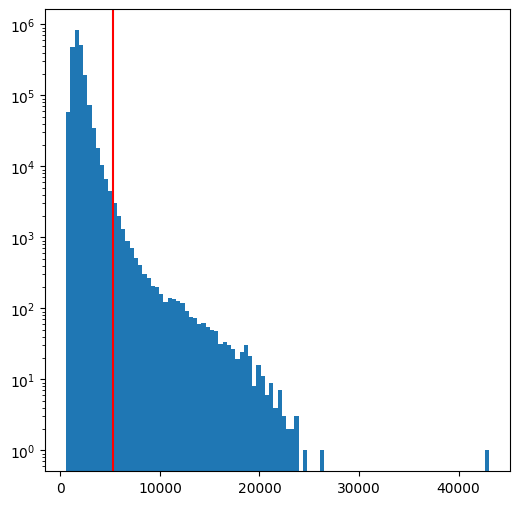

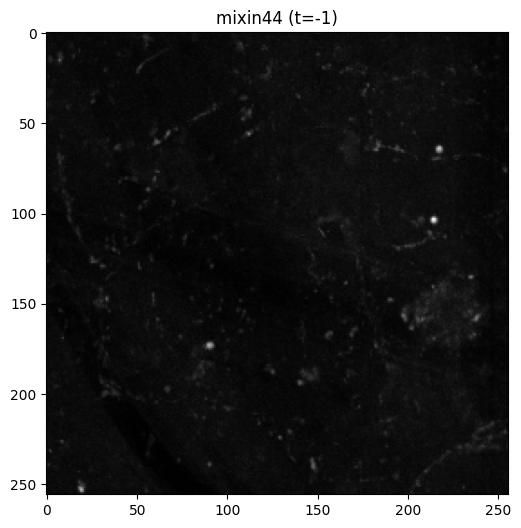

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(test_data_flatten, bins=100, log=True)
plt.axvline(test_data_99p, color='red')
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(test_display_frame, cmap='gray')
plt.title("mixin44 (t=-1)")
plt.show()

Clearly there are some spots that are too bright, the white spot shown in second figure
is not the actual clustering center.

So it would be benefitial to cutoff the top 0.5\%

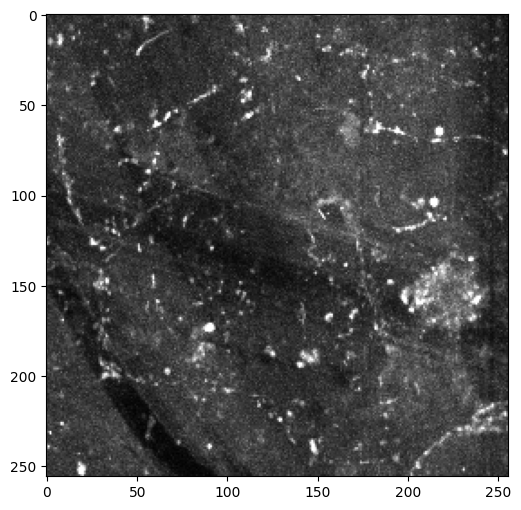

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(test_display_frame, cmap='gray', vmin=np.min(test_data_processed), vmax=test_data_99p)
plt.show()

The cluster is more visible now, but still, there are many light spots.

A method to see the density of light spots is needed. Try Gaussian Blur.

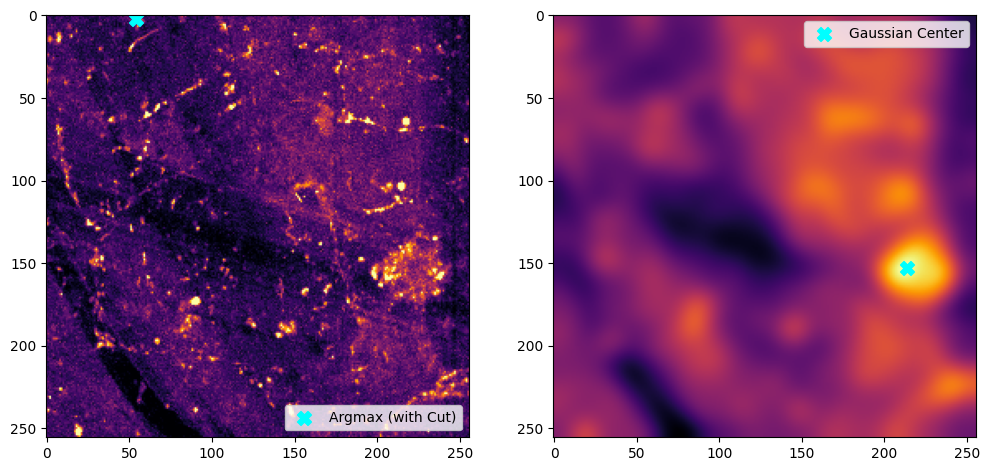

In [ ]:
test_display_frame_cut = np.clip(
    test_display_frame,
    np.percentile(test_display_frame, 1),
    np.percentile(test_display_frame, 99.5)
    )

test_display_y_raw, test_display_x_raw = np.unravel_index(
    np.argmax(test_display_frame_cut), test_display_frame_cut.shape)

test_display_frame_blur = nd.gaussian_filter(test_display_frame_cut, sigma=8)
test_display_y_blur, test_display_x_blur = nd.center_of_mass(
    test_display_frame_blur > np.percentile(test_display_frame_blur, 99.9))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(test_display_frame_cut, cmap='inferno')
axs[0].scatter([test_display_x_raw], [test_display_y_raw], c='cyan', marker='X', s=100, label='Argmax (with Cut)')
axs[0].legend(loc='lower right')
axs[1].imshow(test_display_frame_blur, cmap='inferno')
axs[1].scatter([test_display_x_blur], [test_display_y_blur], c='cyan', marker='X', s=100, label='Gaussian Center')
axs[1].legend()
plt.show()

Clearly the Gaussian mass center is more likely the aggregation center we are looking for.

In [ ]:
class DictyDataset(Dataset):
    def __init__(self, root_dir, folder, N, sigma, augment=False):
        self.N = N
        self.augment = augment
        path = os.path.join(root_dir, folder)
        z = zarr.open(path, mode='r')
        raw = np.max(z[:], axis=2)[:,0,:,:]
        p1 = np.percentile(raw, 1)
        p99 = np.percentile(raw, 99.5)
        raw = np.clip(raw, p1, p99)
        self.data = ((raw - p1) / (p99 - p1 + 1e-9)).astype(np.float32)
        g_blur = nd.gaussian_filter(self.data[-1], sigma=sigma)
        thresh = np.percentile(g_blur, 99.9)
        blur_y, blur_x = nd.center_of_mass(g_blur > thresh)
        self.target_x = blur_x
        self.target_y = blur_y
        self.total_steps = self.data.shape[0] - self.N
    def __len__(self):
        return self.total_steps
    def __getitem__(self, i):
        frame = self.data[i: i+self.N]
        frame = nd.median_filter(frame, size=(1, 3, 3))
        x = torch.from_numpy(frame).unsqueeze(0)
        tx, ty = self.target_x, self.target_y
        time_remaining = 1.0 - (i / max(self.total_steps, 1))
        if self.augment:
            x, tx, ty = self._apply_augmentation(x, tx, ty)
        y = torch.tensor([tx/256, ty/256, time_remaining], dtype = torch.float32)
        return x, y
    def _apply_augmentation(self, x, tx, ty):
        if random.random() > 0.5:
            x = torch.flip(x, dims=[-1])
            tx = 256 - tx
        if random.random() > 0.5:
            x = torch.flip(x, dims=[-2])
            ty = 256 - ty
        k = random.randint(0, 3)
        if k > 0:
            x = torch.rot90(x, k, dims=[-2, -1])
            for _ in range(k):
                old_x = tx
                tx = ty
                ty = 256 - old_x
        return x, tx, ty

This implementation of dataset class included robust normalization.

It applies Gaussian blur to the final frame to try to find the aggregation target, as well as
median filter for `__getitem__`.

# Models

The following models aims to predict the point of aggregation as calculated in the dataset target (`self.target`)

For this coordinate regression task, `SmoothL1Loss` will be used as the loss function, with the following 2 metrics
judging center error ($\mu m$) and resolution robustness.

## Loss function

In [ ]:
class MultiTaskLoss(nn.Module):
    def __init__(self, w_space = 1.0, w_time = 0.5):
        super().__init__()
        self.w_space = w_space
        self.w_time = w_time
        self.criterion = nn.SmoothL1Loss()
    def forward(self, preds, targets):
        pred_coord = preds[:,:2]
        pred_time = preds[:,2]
        target_coord = targets[:,:2]
        target_time = targets[:,2]
        loss_coord = self.criterion(pred_coord, target_coord)
        loss_time = self.criterion(pred_time, target_time)
        total_loss = self.w_space * loss_coord + self.w_time * loss_time
        return total_loss, {"space_loss": loss_coord.item(), "time_loss": loss_time.item()}

For this coordinate regression task, we use SmoothL1Loss to stabilize training. A custom MultiTaskLoss is applied to jointly predict spatial coordinates
(
𝑥
,
𝑦
)
(x,y) and the temporal index
𝑡
t. The total loss is a weighted sum of spatial loss (weight = 1.0) and temporal loss (weight = 0.5), balancing spatial accuracy with temporal consistency.

## Metrics

In [ ]:
@torch.no_grad()
def center_error(preds, targets, pixel_size=1.0, img_size=256.0):
    preds_space = preds[:,:2] * img_size
    targets_space = targets[:,:2] * img_size
    delta = (preds_space - targets_space)
    dist_pixels = torch.norm(delta, p=2, dim=1)
    mean_dist = dist_pixels.mean().item()
    return mean_dist * pixel_size

@torch.no_grad()
def time_error(preds, targets):
    pred_t = preds[:,2]
    target_t = targets[:,2]
    return torch.abs(pred_t - target_t).mean().item()

def evaluate_robustness(model, dataloader, device, factor=0.5, img_size=256.0):
    model.eval()

    total_err_high = 0.0
    total_err_low = 0.0
    total_samples = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            B, C, N, H, W = x.shape

            pred_high = model(x)
            err_high_batch = center_error(pred_high, y)
            total_err_high += err_high_batch * B

            ori_size = (H,W)
            new_size = (int(H * factor), int(W * factor))

            x_reshaped = x.view(B * N, C, H, W)
            x_low = F.interpolate(x_reshaped, size=new_size, mode='bilinear', align_corners=False)
            x_restored = F.interpolate(x_low, size=ori_size, mode='bilinear', align_corners=False)
            x_restored = x_restored.view(B, C, N, H, W)

            pred_low = model(x_restored)
            err_low_batch = center_error(pred_low, y)
            total_err_low += err_low_batch * B
            total_samples += B

    avg_high = total_err_high / total_samples
    avg_low = total_err_low / total_samples

    robustness_score = (avg_low - avg_high) / (avg_high + 1e-9)
    return avg_high, avg_low, robustness_score

We evaluate the model using two metrics:

Center error (µm):
Computes the Euclidean distance between predicted and ground-truth spatial coordinates after scaling back to image space.

Time error:
Measures the absolute difference between the predicted and true temporal index.

Additionally, we assess resolution robustness by comparing model performance under high-resolution input and a downsample-then-upsample degraded version. A robustness score is computed from the relative change in center error between the two settings.

## Model 1

In [ ]:
class MyCNN(nn.Module):
    def __init__(self, output_dim=3):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        )

        self.layer2 = nn.Sequential(
            nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        )

        self.layer3 = nn.Sequential(
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        )

        self.layer4 = nn.Sequential(
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
        )

        self.adaptive_pool = nn.AdaptiveAvgPool3d((1, 4, 4))

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.adaptive_pool(x)
        x = self.regressor(x)

        return x

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_space_loss = 0.0
    running_time_loss = 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss, loss_dict = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        batch_size = x.size(0)
        running_loss += loss.item() * batch_size
        running_space_loss += loss_dict['space_loss'] * batch_size
        running_time_loss += loss_dict['time_loss'] * batch_size

    return running_loss / len(loader.dataset)

@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_space_error = 0.0
    running_time_error = 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss, _ = criterion(outputs, y)
        batch_size = x.size(0)
        running_loss += loss.item() * batch_size
        running_space_error += center_error(outputs, y) * batch_size
        running_time_error += time_error(outputs, y) * batch_size

    dataset_size = len(loader.dataset)
    return running_loss / dataset_size, running_space_error / dataset_size, running_time_error / dataset_size

In [ ]:
model = MyCNN().to(DEVICE)
criterion = MultiTaskLoss(w_space=1.0, w_time=0.3).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)
num_epochs = 100
best_val_error = float('inf')
best_model = None
save_path = "model/best_MyCNN.pth"

In [ ]:
ds1 = DictyDataset(data_path, folder_list[0], N=10, sigma=8, augment=True)
ds2 = DictyDataset(data_path, folder_list[1], N=10, sigma=8, augment=True)
ds3 = DictyDataset(data_path, folder_list[2], N=10, sigma=8, augment=True)
full_dataset = ConcatDataset([ds1, ds2])
total_len = len(full_dataset)

train_ds, val_ds = random_split(
    full_dataset,
    [0.8, 0.2],
    generator=torch.Generator().manual_seed(1)
)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)
test_loader = DataLoader(ds3, batch_size=4, shuffle=False)

In [ ]:
crit_history = {
    'train_loss': [],
    'val_loss': [],
    'val_space_error': [],
    'val_time_error': []
}

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_space_error, val_time_error = validate(model, val_loader, criterion, DEVICE)
    scheduler.step(val_loss)

    crit_history['train_loss'].append(train_loss)
    crit_history['val_loss'].append(val_loss)
    crit_history['val_space_error'].append(val_space_error)
    crit_history['val_time_error'].append(val_time_error)

    if val_space_error < best_val_error:
        best_val_error = val_space_error
        best_model = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), save_path)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Validation error = {val_space_error:.2f}px | {val_time_error:.2f}")

model.load_state_dict(best_model)
test_loss, test_space_error, test_time_error = validate(model, test_loader, criterion, DEVICE)
print(f"Final Test Center Error: {test_space_error:.2f} pixels")
print(f"Final Test Time Error: {test_time_error:.2f}")

avg_high, avg_low, drop_rate = evaluate_robustness(
    model, test_loader, DEVICE, factor=0.5, img_size=256.0
)
print(f"  - High Res Error: {avg_high:.2f} px")
print(f"  - Low Res Error : {avg_low:.2f} px")
print(f"  - Performance Drop: {drop_rate*100:.2f}%")

Epoch 0: Validation error = 64.10px | 0.31%
Epoch 5: Validation error = 27.05px | 0.16%
Epoch 10: Validation error = 19.99px | 0.10%
Epoch 15: Validation error = 25.32px | 0.09%
Epoch 20: Validation error = 22.72px | 0.07%
Epoch 25: Validation error = 15.41px | 0.06%
Epoch 30: Validation error = 22.09px | 0.07%
Epoch 35: Validation error = 18.51px | 0.10%
Epoch 40: Validation error = 14.38px | 0.06%
Epoch 45: Validation error = 13.28px | 0.06%
Epoch 50: Validation error = 11.01px | 0.06%
Epoch 55: Validation error = 11.45px | 0.07%
Epoch 60: Validation error = 7.13px | 0.05%
Epoch 65: Validation error = 8.63px | 0.05%
Epoch 70: Validation error = 7.00px | 0.05%
Epoch 75: Validation error = 5.47px | 0.05%
Epoch 80: Validation error = 7.45px | 0.06%
Epoch 85: Validation error = 7.74px | 0.04%
Epoch 90: Validation error = 5.45px | 0.05%
Epoch 95: Validation error = 6.74px | 0.04%
Final Test Center Error: 42.66 pixels
Final Test Time Error: 0.44 %
  - High Res Error: 45.38 px
  - Low Res E

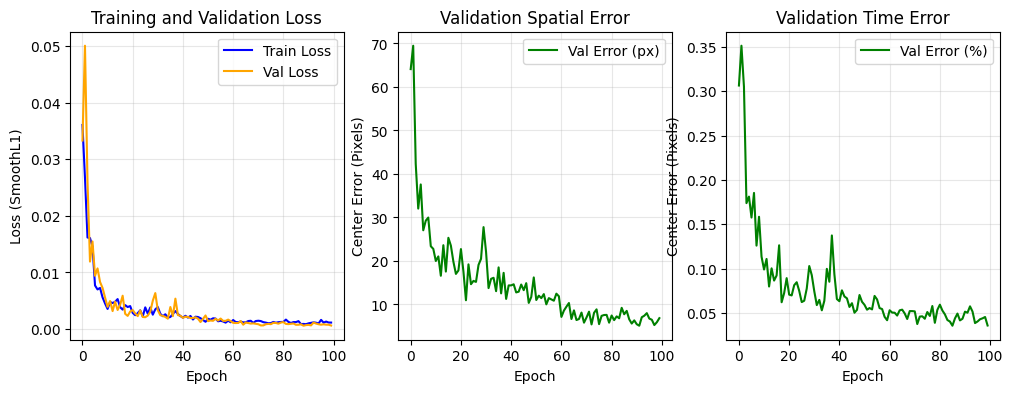

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.plot(crit_history['train_loss'], label='Train Loss', color='blue')
plt.plot(crit_history['val_loss'], label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss (SmoothL1)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(1, 3, 2)
plt.plot(crit_history['val_space_error'], label='Val Error (px)', color='green')
plt.xlabel('Epoch')
plt.ylabel('Center Error (Pixels)')
plt.title('Validation Spatial Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(1, 3, 3)
plt.plot(crit_history['val_time_error'], label='Val Error (%)', color='green')
plt.xlabel('Epoch')
plt.ylabel('Center Error (Pixels)')
plt.title('Validation Time Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Model 1 is a 3D CNN designed to process spatio-temporal input volumes. It consists of four Conv3D blocks with BatchNorm, ReLU, and MaxPool layers, progressively increasing the channel depth from 16 to 128. After feature extraction, an AdaptiveAvgPool3D layer reduces the spatial dimensions, followed by a small MLP regressor that outputs three normalized values
(
𝑥
,
𝑦
,
𝑡
)
(x,y,t) using a final Sigmoid activation.

## Model 2

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, output_dim=3):
        super(CNN_LSTM, self).__init__()

        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)

        self.regressor = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        B, C, N, H, W = x.shape
        x = x.view(B * N, C, H, W)
        xx_channel = torch.linspace(-1, 1, W, device=x.device).view(1, 1, 1, W).expand(B*N, 1, H, W)
        yy_channel = torch.linspace(-1, 1, H, device=x.device).view(1, 1, H, 1).expand(B*N, 1, H, W)
        x = torch.cat([x, xx_channel, yy_channel], dim=1)
        features = self.cnn_backbone(x)
        features = features.view(B, N, -1)
        lstm_out, (h_n, c_n) = self.lstm(features)
        last_hidden = lstm_out[:, -1, :]

        y = self.regressor(last_hidden)
        return y

Conv 2D instead of Conv 3d

coordconv maintained some spatial information
Model 2 combines a 2D CNN backbone with an LSTM to jointly capture spatial and temporal patterns. Each frame is first processed by a CNN feature extractor (Conv2D → BatchNorm → ReLU → MaxPool), producing a 128-dimensional embedding per frame. These per-frame features are then fed into a single-layer LSTM to model temporal evolution across the sequence. The final hidden state is passed through a small regressor network to predict the output coordinates
(
𝑥
,
𝑦
,
𝑡
)
(x,y,t).

Additionally, two coordinate channels (xx, yy) are concatenated to the input frames as positional encoding, helping the model retain spatial structure.

In [ ]:
def train_one_epoch_gc(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_space_loss = 0.0
    running_time_loss = 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss, loss_dict = criterion(outputs, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        batch_size = x.size(0)
        running_loss += loss.item() * batch_size
        running_space_loss += loss_dict['space_loss'] * batch_size
        running_time_loss += loss_dict['time_loss'] * batch_size

    return running_loss / len(loader.dataset)

In [ ]:
model = CNN_LSTM().to(DEVICE)
criterion = MultiTaskLoss(w_space=1.0, w_time=0.3).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)
num_epochs = 100
best_val_error = float('inf')
best_model = None
save_path = "model/best_CNN_LSTM.pth"

In [ ]:
ds1 = DictyDataset(data_path, folder_list[0], N=10, sigma=8, augment=True)
ds2 = DictyDataset(data_path, folder_list[1], N=10, sigma=8, augment=True)
ds3 = DictyDataset(data_path, folder_list[2], N=10, sigma=8, augment=True)
full_dataset = ConcatDataset([ds1, ds2])
total_len = len(full_dataset)

train_ds, val_ds = random_split(
    full_dataset,
    [0.8, 0.2],
    generator=torch.Generator().manual_seed(1)
)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)
test_loader = DataLoader(ds3, batch_size=4, shuffle=False)

In [ ]:
crit_history = {
    'train_loss': [],
    'val_loss': [],
    'val_space_error': [],
    'val_time_error': []
}

for epoch in range(num_epochs):
    train_loss = train_one_epoch_gc(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_space_error, val_time_error = validate(model, val_loader, criterion, DEVICE)
    scheduler.step(val_loss)

    crit_history['train_loss'].append(train_loss)
    crit_history['val_loss'].append(val_loss)
    crit_history['val_space_error'].append(val_space_error)
    crit_history['val_time_error'].append(val_time_error)

    if val_space_error < best_val_error:
        best_val_error = val_space_error
        best_model = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), save_path)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Validation error = {val_space_error:.2f}px | {val_time_error:.2f}")

model.load_state_dict(best_model)
test_loss, test_space_error, test_time_error = validate(model, test_loader, criterion, DEVICE)
print(f"Final Test Center Error: {test_space_error:.2f} pixels")
print(f"Final Test Time Error: {test_time_error:.2f}")

avg_high, avg_low, drop_rate = evaluate_robustness(
    model, test_loader, DEVICE, factor=0.5, img_size=256.0
)
print(f"  - High Res Error: {avg_high:.2f} px")
print(f"  - Low Res Error : {avg_low:.2f} px")
print(f"  - Performance Drop: {drop_rate*100:.2f}%")

Epoch 0: Validation error = 97.19px | 0.44
Epoch 5: Validation error = 67.29px | 0.33
Epoch 10: Validation error = 57.44px | 0.30
Epoch 15: Validation error = 78.54px | 0.32
Epoch 20: Validation error = 56.75px | 0.29
Epoch 25: Validation error = 54.77px | 0.25
Epoch 30: Validation error = 63.20px | 0.27
Epoch 35: Validation error = 54.47px | 0.27
Epoch 40: Validation error = 42.24px | 0.19
Epoch 45: Validation error = 36.01px | 0.19
Epoch 50: Validation error = 40.83px | 0.17
Epoch 55: Validation error = 34.69px | 0.21
Epoch 60: Validation error = 26.82px | 0.17
Epoch 65: Validation error = 30.60px | 0.20
Epoch 70: Validation error = 32.44px | 0.19
Epoch 75: Validation error = 28.51px | 0.16
Epoch 80: Validation error = 26.98px | 0.19
Epoch 85: Validation error = 28.83px | 0.20
Epoch 90: Validation error = 22.44px | 0.16
Epoch 95: Validation error = 21.63px | 0.16
Final Test Center Error: 53.53 pixels
Final Test Time Error: 0.35
  - High Res Error: 50.65 px
  - Low Res Error : 50.61 p

Training follows the same setup as Model 1 (SmoothL1 multi-task loss, Adam optimizer, and ReduceLROnPlateau scheduler), with 100 total epochs. For CNN-LSTM, gradient clipping (max-norm = 1.0) is additionally applied to stabilize LSTM training and prevent exploding gradients.

The dataset is split 80/20 for training and validation, and the best model is selected based on the lowest validation spatial error.

Vs Baseline: worst center, better time (as expected). also better robustness against resolution. Less overfitting

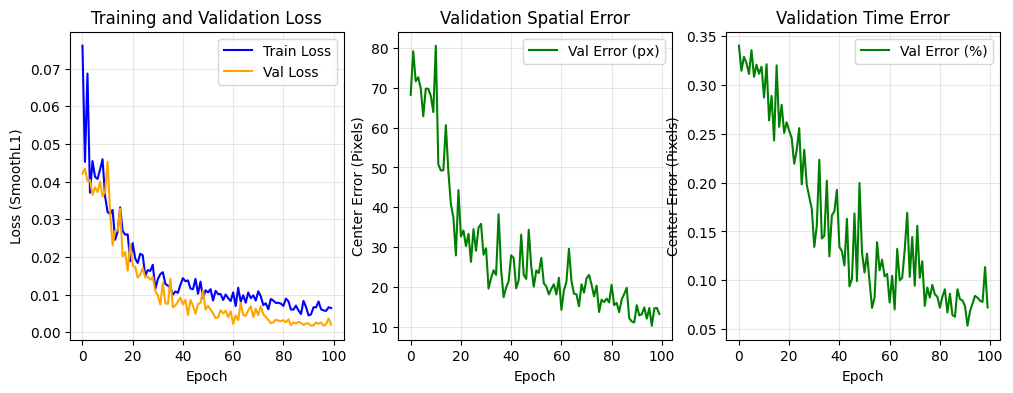

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.plot(crit_history['train_loss'], label='Train Loss', color='blue')
plt.plot(crit_history['val_loss'], label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss (SmoothL1)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(1, 3, 2)
plt.plot(crit_history['val_space_error'], label='Val Error (px)', color='green')
plt.xlabel('Epoch')
plt.ylabel('Center Error (Pixels)')
plt.title('Validation Spatial Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(1, 3, 3)
plt.plot(crit_history['val_time_error'], label='Val Error (%)', color='green')
plt.xlabel('Epoch')
plt.ylabel('Center Error (Pixels)')
plt.title('Validation Time Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

More oscillation than baseline
The first plot shows that both training and validation losses decrease steadily over the first ~20 epochs and then converge to a low, stable range, indicating smooth optimization without signs of severe overfitting.

The second plot reports the validation spatial center error (in pixels). The error drops sharply during the early epochs and continues declining more gradually, showing that the model progressively improves its localization accuracy over time.

The third plot shows the validation time prediction error. Similar to the spatial error, the temporal error decreases consistently and stabilizes at a low level, suggesting that the model learns the temporal component reliably.

## Model 3

In [ ]:
class CNN_Transformer(nn.Module):
    def __init__(self, output_dim=3):
        super(CNN_Transformer, self).__init__()
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.d_model = 128
        self.pos_embedding = nn.Parameter(torch.randn(1, 50, self.d_model)) # Should cover subsetted
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=4,
            dim_feedforward=256,
            dropout=0.3,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.regressor = nn.Sequential(
            nn.Linear(self.d_model, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        B, C, N, H, W = x.shape
        x = x.view(B * N, C, H, W)
        xx_channel = torch.linspace(-1, 1, W, device=x.device).view(1, 1, 1, W).expand(B*N, 1, H, W)
        yy_channel = torch.linspace(-1, 1, H, device=x.device).view(1, 1, H, 1).expand(B*N, 1, H, W)
        x = torch.cat([x, xx_channel, yy_channel], dim=1)
        features = self.cnn_backbone(x)
        features = features.view(B, N, -1)
        features = features + self.pos_embedding[:, :N, :]
        trans_out = self.transformer_encoder(features)
        global_feat = trans_out.mean(dim=1)

        y = self.regressor(global_feat)
        return y

In [ ]:
model = CNN_Transformer().to(DEVICE)
criterion = MultiTaskLoss(w_space=1.0, w_time=0.3).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)
num_epochs = 100
best_val_error = float('inf')
best_model = None
save_path = "model/best_CNN_Transformer.pth"

In [ ]:
ds1 = DictyDataset(data_path, folder_list[0], N=10, sigma=8, augment=True)
ds2 = DictyDataset(data_path, folder_list[1], N=10, sigma=8, augment=True)
ds3 = DictyDataset(data_path, folder_list[2], N=10, sigma=8, augment=True)
full_dataset = ConcatDataset([ds1, ds2])
total_len = len(full_dataset)

train_ds, val_ds = random_split(
    full_dataset,
    [0.8, 0.2],
    generator=torch.Generator().manual_seed(1)
)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)
test_loader = DataLoader(ds3, batch_size=4, shuffle=False)

In [ ]:
crit_history = {
    'train_loss': [],
    'val_loss': [],
    'val_space_error': [],
    'val_time_error': []
}

for epoch in range(num_epochs):
    train_loss = train_one_epoch_gc(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_space_error, val_time_error = validate(model, val_loader, criterion, DEVICE)
    scheduler.step(val_loss)

    crit_history['train_loss'].append(train_loss)
    crit_history['val_loss'].append(val_loss)
    crit_history['val_space_error'].append(val_space_error)
    crit_history['val_time_error'].append(val_time_error)

    if val_space_error < best_val_error:
        best_val_error = val_space_error
        best_model = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), save_path)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Validation error = {val_space_error:.2f}px | {val_time_error:.2f}")

model.load_state_dict(best_model)
test_loss, test_space_error, test_time_error = validate(model, test_loader, criterion, DEVICE)
print(f"Final Test Center Error: {test_space_error:.2f} pixels")
print(f"Final Test Time Error: {test_time_error:.2f}")

avg_high, avg_low, drop_rate = evaluate_robustness(
    model, test_loader, DEVICE, factor=0.5, img_size=256.0
)
print(f"  - High Res Error: {avg_high:.2f} px")
print(f"  - Low Res Error : {avg_low:.2f} px")
print(f"  - Performance Drop: {drop_rate*100:.2f}%")

Epoch 0: Validation error = 124.80px | 0.33
Epoch 5: Validation error = 49.20px | 0.38
Epoch 10: Validation error = 35.31px | 0.25
Epoch 15: Validation error = 83.24px | 0.28
Epoch 20: Validation error = 93.45px | 0.18
Epoch 25: Validation error = 27.84px | 0.21
Epoch 30: Validation error = 31.98px | 0.17
Epoch 35: Validation error = 32.48px | 0.18
Epoch 40: Validation error = 43.93px | 0.16
Epoch 45: Validation error = 35.88px | 0.17
Epoch 50: Validation error = 31.18px | 0.12
Epoch 55: Validation error = 29.04px | 0.14
Epoch 60: Validation error = 25.25px | 0.13
Epoch 65: Validation error = 31.07px | 0.15
Epoch 70: Validation error = 25.00px | 0.15
Epoch 75: Validation error = 30.98px | 0.14
Epoch 80: Validation error = 25.63px | 0.14
Epoch 85: Validation error = 29.93px | 0.13
Epoch 90: Validation error = 23.81px | 0.13
Epoch 95: Validation error = 23.88px | 0.12
Final Test Center Error: 43.68 pixels
Final Test Time Error: 0.34
  - High Res Error: 55.87 px
  - Low Res Error : 55.19 

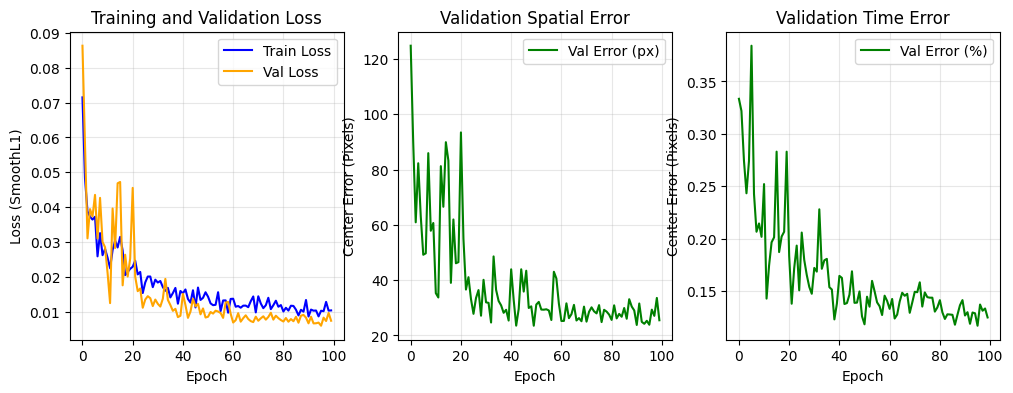

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.plot(crit_history['train_loss'], label='Train Loss', color='blue')
plt.plot(crit_history['val_loss'], label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss (SmoothL1)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(1, 3, 2)
plt.plot(crit_history['val_space_error'], label='Val Error (px)', color='green')
plt.xlabel('Epoch')
plt.ylabel('Center Error (Pixels)')
plt.title('Validation Spatial Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(1, 3, 3)
plt.plot(crit_history['val_time_error'], label='Val Error (%)', color='green')
plt.xlabel('Epoch')
plt.ylabel('Center Error (Pixels)')
plt.title('Validation Time Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Model 3 replaces the recurrent module with a Transformer encoder to better capture long-range temporal dependencies. Each frame first passes through a CNN backbone that extracts a 128-dimensional feature vector. These per-frame features are arranged into a sequence and combined with a learnable positional embedding. The sequence is then processed by a 2-layer Transformer encoder (4 heads, hidden size 256). The output features are averaged across time to obtain a global representation, which is fed into an MLP regressor to predict the
(
𝑥
,
𝑦
,
𝑡
)
(x,y,t) coordinates.

# Evaluation

In [ ]:
def collect_test_results(model, loader, device, img_size=256.0):
    model.eval()
    all_spatial_errors = []
    all_time_errors = []

    all_time_targets = []
    all_images = []
    all_preds_xy = []
    all_targets_xy = []
    total_samples = len(loader.dataset)
    vis_interval = max(1, total_samples // 10)

    sample_count = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)

            preds_space = torch.clamp(outputs[:, :2], 0, 1) * img_size
            targets_space = y[:, :2] * img_size
            delta = preds_space - targets_space
            spatial_dists = torch.norm(delta, p=2, dim=1).cpu().numpy()
            all_spatial_errors.extend(spatial_dists)

            preds_time = outputs[:, 2]
            targets_time = y[:, 2]
            time_dists = torch.abs(preds_time - targets_time).cpu().numpy()
            all_time_errors.extend(time_dists)

            all_time_targets.extend(targets_time.cpu().numpy())
            batch_size = x.size(0)
            for b in range(batch_size):
                if sample_count % vis_interval == 0 and len(all_images) < 8:
                    first_frame = x[b, 0, 0, :, :].cpu().numpy()
                    all_images.append(first_frame)
                    all_preds_xy.append(preds_space[b].cpu().numpy())
                    all_targets_xy.append(targets_space[b].cpu().numpy())

                sample_count += 1

    return np.array(all_spatial_errors), np.array(all_time_errors), \
           np.array(all_time_targets), np.array(all_images), \
           np.array(all_preds_xy), np.array(all_targets_xy)
def compute_robustness(model, loader, device, factor=0.5, img_size=256.0):
    model.eval()
    total_err_high = 0.0
    total_err_low = 0.0
    count = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            B, C, N, H, W = x.shape

            pred_high = model(x)
            preds_space_h = torch.clamp(pred_high[:, :2], 0, 1) * img_size
            targets_space = y[:, :2] * img_size
            err_high = torch.norm(preds_space_h - targets_space, p=2, dim=1).sum().item()

            ori_size = (H, W)
            new_size = (int(H * factor), int(W * factor))
            x_reshaped = x.view(B * N, C, H, W)
            x_low = F.interpolate(x_reshaped, size=new_size, mode='bilinear', align_corners=False)
            x_restored = F.interpolate(x_low, size=ori_size, mode='bilinear', align_corners=False)
            x_restored = x_restored.view(B, C, N, H, W)
            pred_low = model(x_restored)
            preds_space_l = torch.clamp(pred_low[:, :2], 0, 1) * img_size
            err_low = torch.norm(preds_space_l - targets_space, p=2, dim=1).sum().item()

            total_err_high += err_high
            total_err_low += err_low
            count += B

    avg_high = total_err_high / count
    avg_low = total_err_low / count
    drop_rate = (avg_low - avg_high) / (avg_high + 1e-9)

    return avg_high, avg_low, drop_rate
def get_metrics_df(model_name, spatial_errs, time_errs, rob_stats):
    def calculate_stats(data):
        mean_val = np.mean(data)
        sem = stats.sem(data)
        ci_val = sem * stats.t.ppf((1 + 0.95) / 2., len(data) - 1)
        return mean_val, ci_val
    s_mean, s_ci = calculate_stats(spatial_errs)
    t_mean, t_ci = calculate_stats(time_errs)
    rob_high, rob_low, rob_drop = rob_stats
    data = [
        {
            "Metric": "Center Error (μm/px)",
            "Mean Value": f"{s_mean:.2f}",
            "95% CI (±)": f"{s_ci:.2f}",
            "Description": "Spatial accuracy (lower is better)"
        },
        {
            "Metric": "Time Error (Abs)",
            "Mean Value": f"{t_mean:.3f}",
            "95% CI (±)": f"{t_ci:.3f}",
            "Description": "Temporal accuracy (0.0-1.0 scale)"
        },
        {
            "Metric": "Robustness Drop",
            "Mean Value": f"{rob_drop*100:.2f}%",
            "95% CI (±)": "-",
            "Description": f"Perf. drop at 0.5x resolution"
        },
        {
            "Metric": "High-Res Error",
            "Mean Value": f"{rob_high:.2f}",
            "95% CI (±)": "-",
            "Description": "Baseline for robustness"
        },
        {
            "Metric": "Low-Res Error",
            "Mean Value": f"{rob_low:.2f}",
            "95% CI (±)": "-",
            "Description": "Simulation for robustness"
        }
    ]
    df = pd.DataFrame(data)

    return df

def plot_figure_1(model_name, images, preds, targets):
    plt.figure(figsize=(16, 4))
    for i in range(4):
        if i >= len(images): break
        plt.subplot(1, 4, i+1)
        plt.imshow(images[i], cmap='gray', origin='upper')
        plt.scatter(targets[i][0], targets[i][1], c='lime', s=80, marker='o', edgecolors='k', label='GT')
        plt.scatter(preds[i][0], preds[i][1], c='red', s=80, marker='x', linewidth=2, label='Pred')

        if i == 0: plt.legend()
        plt.title(f"Sample {i+1}")
        plt.axis('off')

    plt.suptitle(f"{model_name}: Predictions on Early Frames", fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_figure_2(model_name, errors, time_targets):
    progress = (1.0 - time_targets) * 100
    bins = np.linspace(0, 100, 11) # 0, 10, 20... 100
    bin_centers = (bins[:-1] + bins[1:]) / 2
    binned_errs = []
    valid_centers = []

    for i in range(len(bins)-1):
        mask = (progress >= bins[i]) & (progress < bins[i+1])
        if np.sum(mask) > 0:
            avg = np.mean(errors[mask])
            binned_errs.append(avg)
            valid_centers.append(bin_centers[i])
        else:
            pass

    plt.figure(figsize=(8, 5))
    plt.plot(valid_centers, binned_errs, marker='o', linewidth=3, label=f'{model_name} Mean Trend')
    plt.scatter(progress, errors, alpha=0.1, color='gray', s=10, label='Individual Samples')

    plt.xlabel("Experiment Progress (%)")
    plt.ylabel("Center Error (Pixels)")
    plt.title(f"{model_name}: Error vs. Time Analysis")
    plt.grid(True, alpha=0.3)
    plt.ylim(20,70)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
ds3 = DictyDataset(data_path, folder_list[2], N=10, sigma=8, augment=False)
test_loader = DataLoader(ds3, batch_size=4, shuffle=False)

,Metric,Mean Value,95% CI (±),Description
0,Center Error (μm/px),51.28,2.94,Spatial accuracy (lower is better)
1,Time Error (Abs),0.444,0.216,Temporal accuracy (0.0-1.0 scale)
2,Robustness Drop,-4.54%,-,Perf. drop at 0.5x resolution
3,High-Res Error,51.28,-,Baseline for robustness
4,Low-Res Error,48.95,-,Simulation for robustness


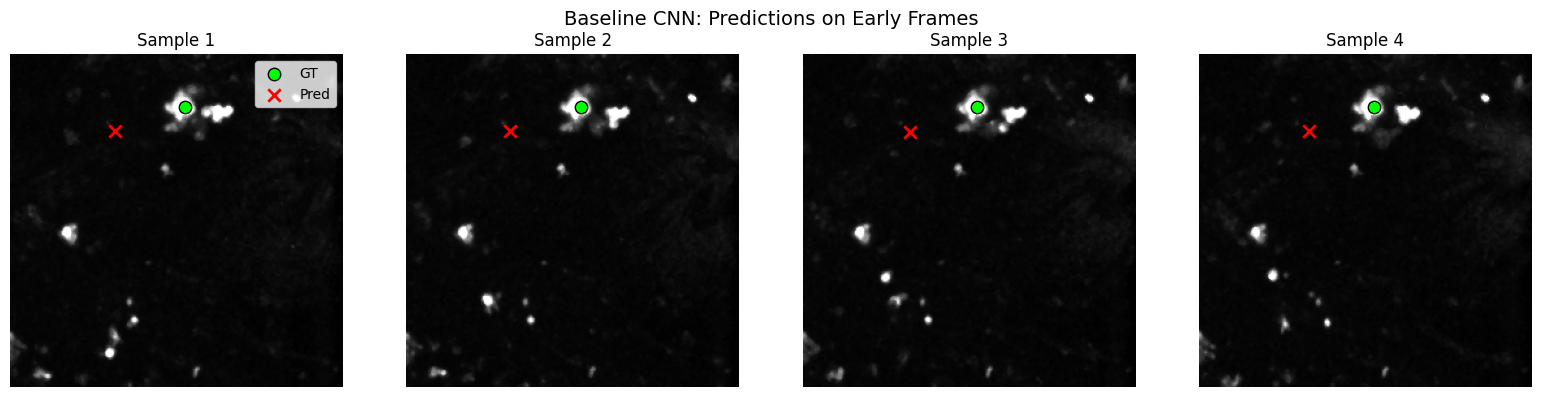

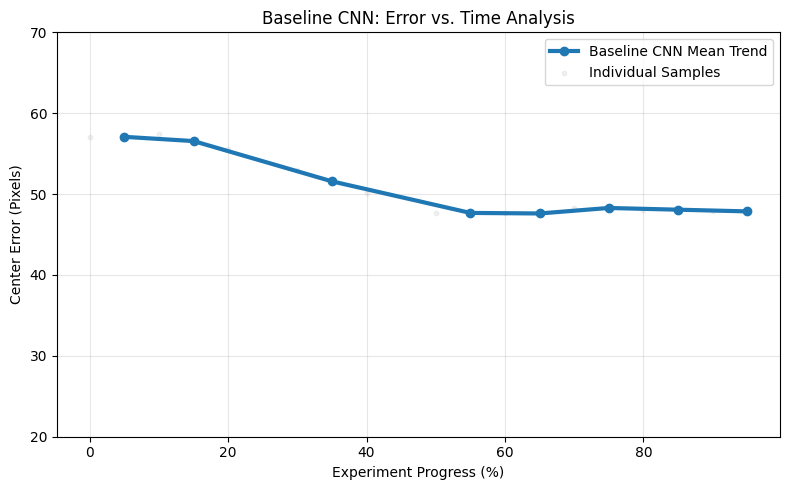

In [ ]:
evaluate_model = MyCNN().to(DEVICE)
evaluate_path = "model/best_MyCNN.pth"
evaluate_model.load_state_dict(torch.load(evaluate_path, map_location=DEVICE))
spatial_errs, time_errs, times_tgt, imgs, preds_xy, tgts_xy = collect_test_results(
    evaluate_model, test_loader, DEVICE
)
rob_stats = compute_robustness(
    evaluate_model, test_loader, DEVICE, factor=0.5
)
df_results = get_metrics_df("Baseline CNN", spatial_errs, time_errs, rob_stats)
display(df_results)
plot_figure_1("Baseline CNN", imgs, preds_xy, tgts_xy)
plot_figure_2("Baseline CNN", spatial_errs, times_tgt)

For evaluation, the model is run in inference mode to compute spatial and temporal errors on the test set. Spatial error is measured as the Euclidean distance between predicted and ground-truth centers (in pixel units), while temporal error is computed as the absolute difference in the predicted time index.

During evaluation, a small subset of early frames is collected for qualitative visualization, showing predicted centers overlaid on the input images. In addition, robustness is assessed by comparing performance on high-resolution inputs to a simulated low-resolution version produced via downsampling and upsampling. A robustness drop score is calculated as the relative change in center error.

Finally, all metrics (mean, 95% CI) are aggregated into a summary table, and two figures are generated:
(1) early-frame prediction visualizations, and
(2) error vs. experiment-progress analysis.

,Metric,Mean Value,95% CI (±),Description
0,Center Error (μm/px),48.38,0.32,Spatial accuracy (lower is better)
1,Time Error (Abs),0.338,0.178,Temporal accuracy (0.0-1.0 scale)
2,Robustness Drop,1.91%,-,Perf. drop at 0.5x resolution
3,High-Res Error,48.38,-,Baseline for robustness
4,Low-Res Error,49.30,-,Simulation for robustness


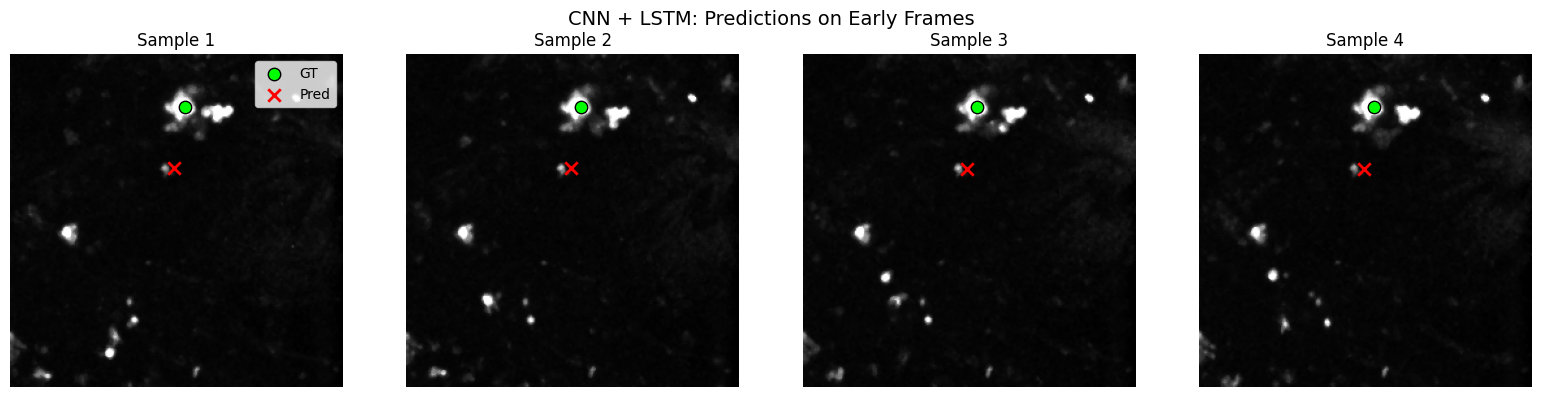

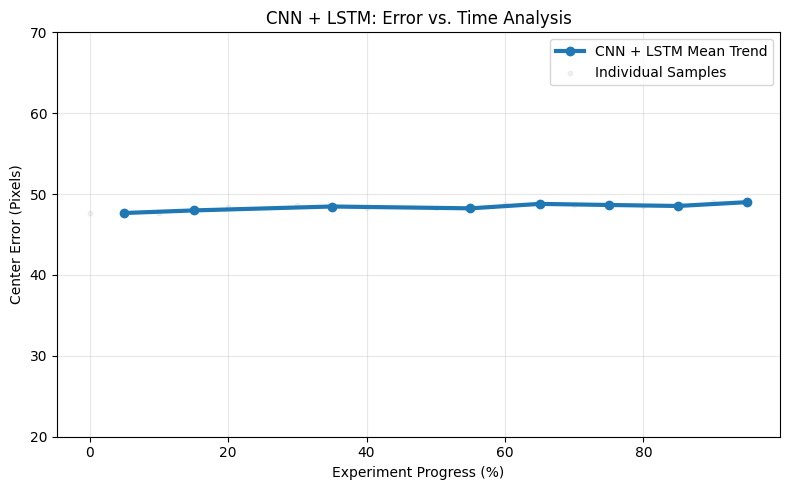

In [ ]:
evaluate_model = CNN_LSTM().to(DEVICE)
evaluate_path = "model/best_CNN_LSTM.pth"
evaluate_model.load_state_dict(torch.load(evaluate_path, map_location=DEVICE))
spatial_errs, time_errs, times_tgt, imgs, preds_xy, tgts_xy = collect_test_results(
    evaluate_model, test_loader, DEVICE
)
rob_stats = compute_robustness(
    evaluate_model, test_loader, DEVICE, factor=0.5
)
df_results = get_metrics_df("Baseline CNN", spatial_errs, time_errs, rob_stats)
display(df_results)
plot_figure_1("CNN + LSTM", imgs, preds_xy, tgts_xy)
plot_figure_2("CNN + LSTM", spatial_errs, times_tgt)

Metrics Table

The CNN+LSTM model achieves a center error of ~48 px and a time error of ~0.34. Robustness is stable, with only ~2% performance drop under low-resolution simulation.

Early-Frame Predictions

Early-frame visualizations show that predicted centers are close to ground truth, indicating the model can localize hotspots even before aggregation fully appears.

Error vs. Time

The center error stays nearly flat across experiment progress, suggesting that CNN+LSTM maintains consistent spatial accuracy over time.

,Metric,Mean Value,95% CI (±),Description
0,Center Error (μm/px),44.08,1.01,Spatial accuracy (lower is better)
1,Time Error (Abs),0.345,0.181,Temporal accuracy (0.0-1.0 scale)
2,Robustness Drop,-0.14%,-,Perf. drop at 0.5x resolution
3,High-Res Error,44.08,-,Baseline for robustness
4,Low-Res Error,44.02,-,Simulation for robustness


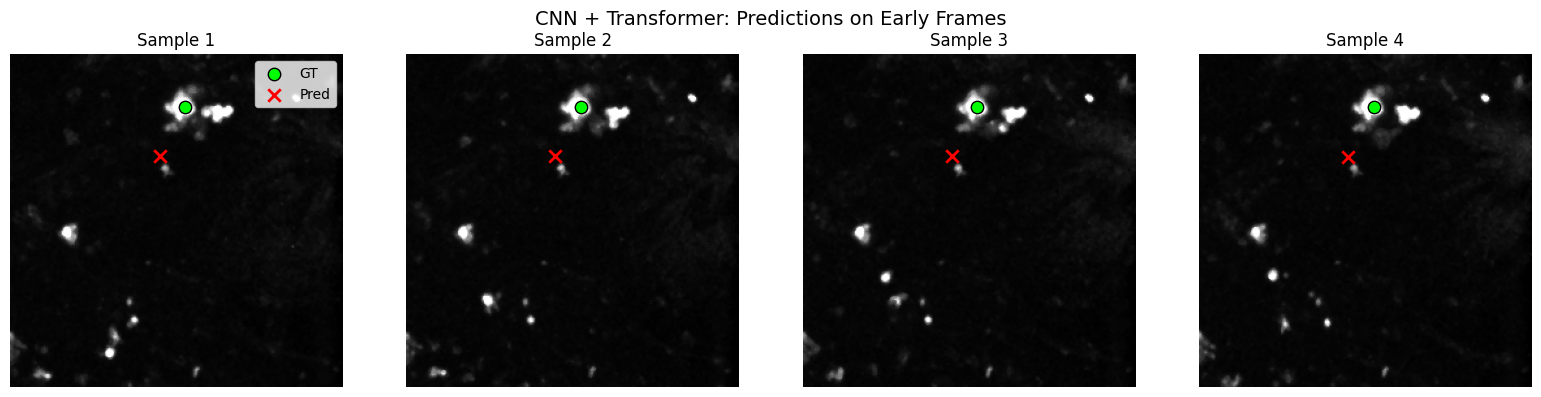

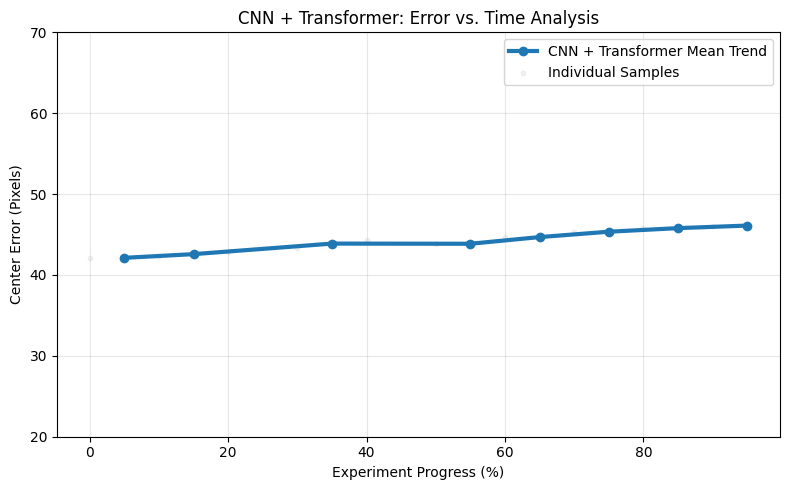

In [ ]:
evaluate_model = CNN_Transformer().to(DEVICE)
evaluate_path = "model/best_CNN_Transformer.pth"
evaluate_model.load_state_dict(torch.load(evaluate_path, map_location=DEVICE))
spatial_errs, time_errs, times_tgt, imgs, preds_xy, tgts_xy = collect_test_results(
    evaluate_model, test_loader, DEVICE
)
rob_stats = compute_robustness(
    evaluate_model, test_loader, DEVICE, factor=0.5
)
df_results = get_metrics_df("Baseline CNN", spatial_errs, time_errs, rob_stats)
display(df_results)
plot_figure_1("CNN + Transformer", imgs, preds_xy, tgts_xy)
plot_figure_2("CNN + Transformer", spatial_errs, times_tgt)

Metrics Table

The Transformer model achieves a center error of ~44 px and a time error of ~0.34, showing the best spatial accuracy among all models with almost no robustness drop (≈0%).

Early-Frame Predictions

Qualitative examples show consistently accurate early-frame localization, indicating that the Transformer effectively captures spatial cues even when the hotspot is faint.

Error vs. Time Curve

The error remains stable across experiment progress, with a slight upward trend, suggesting steady performance and limited reliance on late-frame information.

Future work will include expanding the dataset, increasing training epochs, and adopting 3-fold cross-validation for more reliable performance estimates.
It is also worth noting that the three datasets differ in acquisition parameters (e.g., time interval, subsampling rate, pixel size, and z-step). The test set (Mixin64) diverges the most from the training data, which likely contributes to the performance gap. Using a more consistent or better-matched test set may lead to more meaningful evaluation and improved generalization.